## GAN의 문제점
- MNIST GAN을 통해 0~9까지 학습 완료!
- GAN이 생성한 7 이미지를 얻고 싶으면?
- GAN을 돌리고, 7이 나올떄 까지 기다려야함.
 => 내가 생성하고자 하는 데이터를 제어하기 힘듬.(Unconditional Generative Model)
 
## cGAN(Conditional Generative Model)

 - 내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법
 


### GAN과 cGAN의 목적함수

 #### GAN
![image.png](E24im1.png)
 
 - 먼저 GAN에 대해 간단히 복습해봅시다. GAN 구조는 Generator 및 Discriminator라 불리는 두 신경망이 minimax game을 통해 서로 경쟁하며 발전합니다. 이를 아래와 같은 식으로 나타낼 수 있으며 Generator는 이 식을 최소화하려, Discriminator는 이 식을 최대화하려 학습합니다
 
 - z= 노이즈, D ,G = Discriminator, Generator
 
 - D 입장에서 : 실제 이미지가 1, 가짜 이미지가 0이면 D는 이 식을 최대화 해야함.
 logD(x) , long(1-D(G(z))가 모두 최대
 ==> D(x)는 1, D(G(z)) 는 0으로 가야함
 
 - G 입장에서 : log(1-D(G(z))만 최소화 하면 됨. log 내부가 0이 되도록 해야하고, D(G(z))가 1이 되도록 해야함
 
 #### cGAN
 
![image.png](E24im2.png)

 - cGAN은 조건부확률 y가 추가됨. y가 생성하고 싶은 target
 - y까 임의 노이즈 z의 가이드 역할을 수행

![image.png](E24im3.png)

 - Generator
노이즈 z(파란색)가 입력되고 특정 representation(검정색)으로 변환된 후 가짜 데이터 G(z)(빨간색)를 생성해 냅니다.

- Discriminator
실제 데이터 x와 Generator가 생성한 가짜 데이터 G(z)를 각각 입력받아 D(x)
 및 D(G(z))(보라색)를 계산하여 진짜와 가짜를 식별해 냅니다.



![image.png](E24im4.png)

 - Generator 
 노이즈 z(파란색)와 추가 정보 y(녹색)을 함께 입력받아 Generator 내부에서 결합되어 representation(검정색)으로 변환되며 가짜 데이터 
G(z∣y)를 생성합니다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 
y는 레이블 정보이며, 일반적으로 one-hot 벡터를 입력으로 넣습니다.
 - Discriminator 실제 데이터 x와 Generator가 생성한 가짜 데이터 G(z∣y)를 각각 입력받으며, 마찬가지로 y정보가 각각 함께 입력되어 진짜와 가짜를 식별합니다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 실제 데이터 x와 y는 알맞은 한 쌍("7"이라 쓰인 이미지의 경우 레이블도 7)을 이뤄야 하며, 마찬가지로 Generator에 입력된 y와 Discriminator에 입력되는 y는 동일한 레이블을 나타내야 합니다.

[코드 참고] https://github.com/thisisiron/TF2-GAN/blob/master/cgan/model.py

```
$ pip install tensorflow-datasets
```

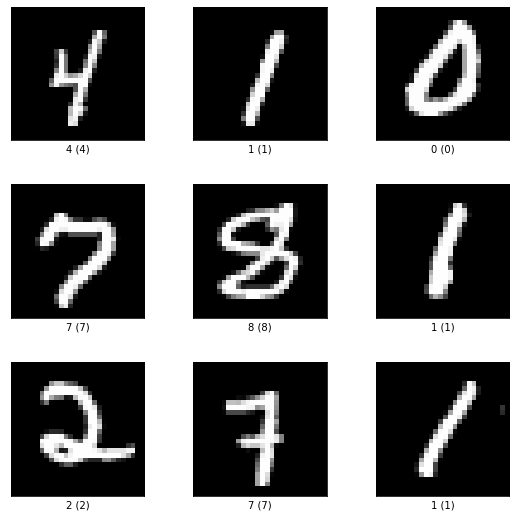

In [1]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

In [2]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


 - 이미지 픽셀 값을 -1~1 사이의 범위로 변경했고, 레이블 정보를 one-hot encoding 했습니다.
 - GAN과 cGAN 각각을 실험해 보기 위해 label 정보 사용 유무에 따라 두 가지 함수를 구성해 놓았습니다.

In [4]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

Label : tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


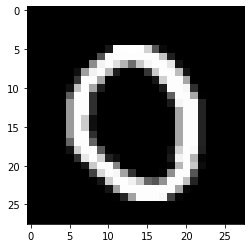

In [5]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

## GAN Generator 구성

In [7]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

## cGAN Generator 구성하기

In [9]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    

 1. 노이즈 입력 및 레이블 입력은 각각 1개의 fully-connected 레이어와 ReLU 활성화를 통과합니다. (dense_z, dense_y)  

 2. 1번 문항의 각 결과가 서로 연결되어 다시 한번 1개의 fully-connected 레이어와 ReLU 활성화를 통과합니다 (tf.concat, conbined_dense)  

 3. 2번 문항의 결과가 1개의 fully-connected 레이어 및 Hyperbolic tangent 활성화를 거쳐 28x28 차원의 결과가 생성되고 (28,28,1) 크기의 이미지 형태로 변환되어 출력됩니다 (final_dense, reshape)

## GAN Discriminator

In [11]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x


## cGAN Discriminator

 - Maxout Layer가 사용된다.
 
 두 레이어 사이를 연결할 때, 여러 개의 Fully-Connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록 함.
 [참고] https://m.blog.naver.com/PostView.nhn?blogId=laonple&logNo=221259325819&proxyReferer=&proxyReferer=https:%2F%2Fwww.google.com%2F

In [13]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

Maxout 레이어를 구성할 때 units과 pieces의 설정이 필요하며, units 차원 수를 가진 fully-connected 레이어를 pieces개 만큼 만들고 그 중 최대 값을 출력합니다.
예를 들어, 사용할 Maxout 레이어가 units=100, pieces=10으로 설정 된다면 입력으로 부터 100차원의 representation을 10개 만들고,
10개 중에서 최대값을 가져와 최종 1개의 100차원 representation이 출력됩니다. 식으로 나타낸다면 아래와 같습니다. (위 예시에서는 각각의 wx+b가 모두 100차원 입니다)

In [15]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    

Generator가 생성한 (28,28,1) 크기의 이미지가 입력되므로, layers.Flatten()이 적용됩니다.
그리고 이미지 입력 및 레이블 입력 각각은 Maxout 레이어를 한번씩 통과한 후 서로 결합되어 Maxout 레이어를 한번 더 통과합니다.
마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력됩니다.

 - 이미지가 Maxout 레이어를 통과 : 240 차원

 - 레이블이 Maxout 레이어를 통과 : 50 차원

 - 1)과 2)결과로 나온 representation을 결합(concate) 후 Maxout 레이어를 통과
: 240


 ## Loss Function과 Optimizer 정의

In [17]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

## GAN으로 MNIST 학습하기

In [19]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

In [20]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.016486167907715, D:0.15476106107234955
[1/10 EPOCHS, 200 ITER] G:2.138667345046997, D:0.15934708714485168
[1/10 EPOCHS, 300 ITER] G:2.414992094039917, D:0.125081405043602
[1/10 EPOCHS, 400 ITER] G:2.9103946685791016, D:0.10427418351173401
[2/10 EPOCHS, 100 ITER] G:3.485588550567627, D:0.0926133245229721
[2/10 EPOCHS, 200 ITER] G:3.603456497192383, D:0.128611221909523
[2/10 EPOCHS, 300 ITER] G:2.8987724781036377, D:0.19041389226913452
[2/10 EPOCHS, 400 ITER] G:3.5001349449157715, D:0.11779642850160599
[3/10 EPOCHS, 100 ITER] G:3.792691707611084, D:0.22335687279701233
[3/10 EPOCHS, 200 ITER] G:3.1917848587036133, D:0.1168452724814415
[3/10 EPOCHS, 300 ITER] G:4.713610649108887, D:0.13991200923919678
[3/10 EPOCHS, 400 ITER] G:4.790991306304932, D:0.12848971784114838
[4/10 EPOCHS, 100 ITER] G:4.186100959777832, D:0.037605058401823044
[4/10 EPOCHS, 200 ITER] G:4.162373065948486, D:0.057915158569812775
[4/10 EPOCHS, 300 ITER] G:3.188492774963379, D:0.1204552277922

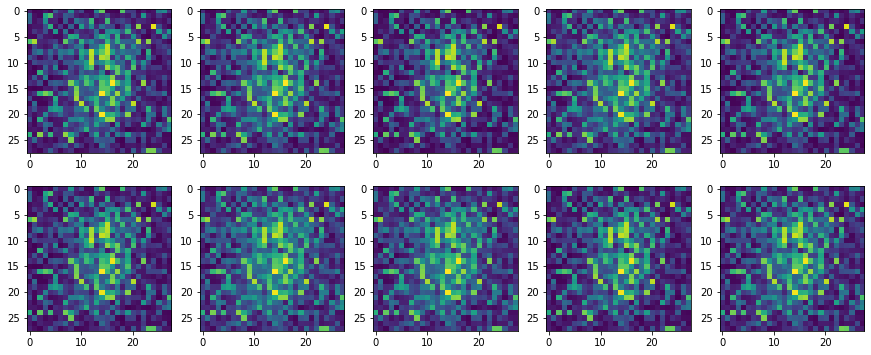

In [21]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

#### 10 Epoch로는 좋은 결과가 나오기 힘듬..
#### 500 Epoch 학습한 가중치 다운로드 해서 확인해보자.

https://aiffelstaticprd.blob.core.windows.net/media/documents/GAN_500.zip

```
$ mkdir -p ~/aiffel/conditional_generation/gan
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/GAN_500.zip
$ mv GAN_500.zip ~/aiffel/conditional_generation/gan
$ cd ~/aiffel/conditional_generation/gan && unzip GAN_500.zip
```

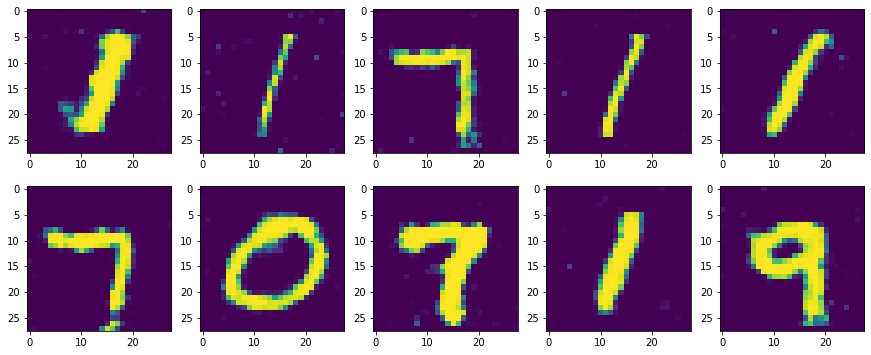

In [22]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

## cGAN으로 MNIST학습하기

In [23]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:4.591582298278809, D:0.02738548070192337
[1/1 EPOCHS, 199 ITER] G:4.317388534545898, D:0.029899118468165398
[1/1 EPOCHS, 299 ITER] G:5.654394149780273, D:0.028977565467357635
[1/1 EPOCHS, 399 ITER] G:4.660700798034668, D:0.02452336624264717


#### cGAN 500 epoch 학습한 가중치
https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip

```
$ mkdir -p ~/aiffel/conditional_generation/cgan
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip
$ mv CGAN_500.zip ~/aiffel/conditional_generation/cgan
$ cd ~/aiffel/conditional_generation/cgan && unzip CGAN_500.zip
```

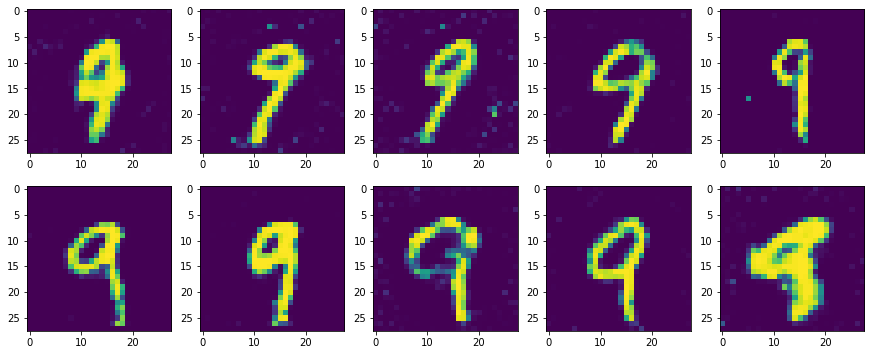

In [27]:
number = 9  # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

### GAN 입력에 이미지 넣기, Pix2Pix